In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step 1. 데이터 불러오기
   

In [2]:
data_dir = os.getenv("HOME") + '/aiffel/DATA'

In [3]:
data_test_path = data_dir+"/data_test_spm_4000_0317.pkl"
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test['weight'] = full_data_test['tok_cat'].apply(lambda x : 14 - x)
full_data_test = full_data_test.loc[full_data_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림
test_idx = full_data_test.index

In [4]:
# # train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
data_train_path = data_dir+"/data_train_custom_msp_8000_0322.pkl"
data_test_path = data_dir+"/data_test_custom_msp_8000_0322.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test = full_data_test.iloc[test_idx].copy()

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340262 entries, 0 to 1340261
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   reg       1340262 non-null  object
 1   topic     1340262 non-null  object
 2   eng       1340262 non-null  object
 3   dial      1340262 non-null  object
 4   tok_len   1340262 non-null  int64 
 5   tok_cat   1340262 non-null  int64 
 6   toks_en   1340262 non-null  object
 7   toks_dec  1340262 non-null  object
dtypes: int64(2), object(6)
memory usage: 81.8+ MB


In [6]:
full_data.head(2)

,reg,topic,eng,dial,tok_len,tok_cat,toks_en,toks_dec
0,jd,역사,<jd> I've changed my mind a little bit.,생각이 쪼금씩 바뀌드라고,10,1,"[7951, 5, 12, 7973, 35, 934, 104, 866, 10, 77,...","[1, 95, 6471, 2442, 6854, 2315, 913, 2]"
1,jd,가족,<jd> You know what? Foreigners still get used ...,웜마 알겄는가 애국인들이 그또 달 적응하고,17,1,"[7951, 5, 115, 141, 162, 7978, 6239, 851, 259,...","[1, 708, 6495, 61, 6787, 6474, 6472, 5875, 649..."


In [7]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1362 to 893
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       250 non-null    object
 1   topic     250 non-null    object
 2   eng       250 non-null    object
 3   dial      250 non-null    object
 4   tok_len   250 non-null    int64 
 5   tok_cat   250 non-null    int64 
 6   toks_en   250 non-null    object
 7   toks_dec  250 non-null    object
dtypes: int64(2), object(6)
memory usage: 17.6+ KB


In [8]:
regs = full_data.reg.unique()

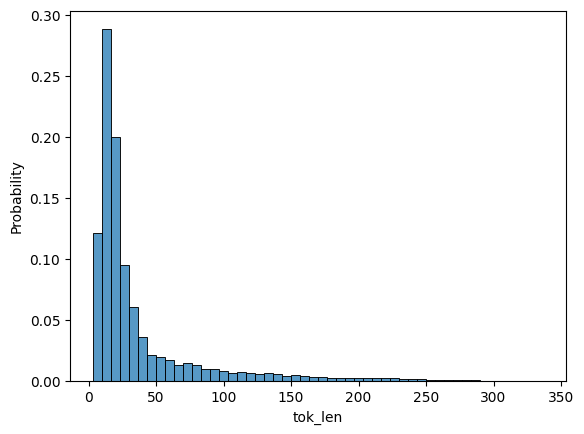

In [9]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_dec'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [10]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    44.048479
gs    42.905380
jd    39.006957
jj    28.895504
kw    30.739265
Name: tok_len, dtype: float64

In [11]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.7,0.8,0.85,0.9,0.92,0.94,0.96,0.98,0.985,0.986,0.994,0.999,1],labels =[1,2,3,4,5,6,7,8,9,10,11,12,13])

In [12]:
full_data.loc[full_data['tok_cat']==7,'tok_len'].agg([min,max])

min    120
max    143
Name: tok_len, dtype: int64

In [13]:
data_path = os.getenv('HOME') + '/aiffel/saturi/notebook/Preprocessing/'
SRC_VOCAB_SIZE = 8009
TGT_VOCAB_SIZE = 8009

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_8009.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+'/spm_dec_custom_msp8009.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델불러오기

In [14]:
import wandb
wandb.login()

wandb: Currently logged in as: seuyon0101. Use `wandb login --relogin` to force relogin


True

In [15]:
#wandb 설정
run  = wandb.init(project = 'model_exp_custom_msp_8009_0322v_test_max',
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer',
                     'n_layers':6,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len': 512,
                     'dropout':0.2,
                     'shared':True,
                     'warmups' : 4000,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                 })
config = wandb.config

wandb: Currently logged in as: seuyon0101 (saturi). Use `wandb login --relogin` to force relogin


In [16]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [17]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

2023-03-23 01:37:24.072874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 01:37:24.886221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14628 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [18]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [19]:
learningrate = LearningRateScheduler(512)

In [20]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [21]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [22]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [23]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [24]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0
        total_loss_val = 0
        bleu_train = 0
        bleu_valid = 0
        

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                         dec_train[idx:idx+batch_size],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss
            
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
            
        #validation
        for test_idx in range(0,enc_test.shape[0], batch_size) :
            val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + batch_size],
                                      dec_test[test_idx : test_idx + batch_size],
                                      transformer)
            total_loss_val += val_loss

        wandb.log({
                   "train_loss": total_loss.numpy() / (len(t) + 1),
                   "valid_loss" : total_loss_val.numpy() / (enc_test.shape[0]//batch_size),
                   })

        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +'tf_custom_msp8000_ckpt_0322v_max',max_to_keep=3)

## 학습

In [ ]:
#bucketing and training

batch_size = 32
buckets = iter(full_data['tok_cat'].unique().tolist()[:4])

for bucket in buckets :

    src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
    tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
    src_valid_corpus = full_data_test['toks_en'].values
    tgt_valid_corpus = full_data_test['toks_dec'].values
    max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()
    
    if max_len > 380 :
        batch_size = 8
        
    if max_len > 512 : 
        max_len = 512
        
    enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
    dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
    enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
    dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)

    print(enc_train.shape)
    print(dec_train.shape)
    print(enc_test.shape)
    print(dec_test.shape)
    
    
    #Train
    train_and_checkpoint(transformer, manager, config.epochs)

(944749, 29)
(944749, 29)
(250, 29)
(250, 29)
Restored from /home/seuyon0101/aiffel/MODEL/tf_custom_msp8000_ckpt_0322v_max/ckpt-5


Epoch  1:  17%|██▌            | 5042/29524 [04:05<18:38, 21.88it/s, Loss 2.8651]

# Step 3. 평가

In [162]:
from evaluation import translate
from time import perf_counter

In [186]:
# eval

import seaborn
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from preprocess import preprocess_sentence
from vanilla_transformer import Transformer, generate_masks

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)
    max_len = len(tokens)
    if max_len > 512 :
        max_len = 512

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=max_len, padding='post')

    ids = []

    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return ids, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, verbose =False , plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    if verbose :
        print('Input: %s' % (sentence))
        print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
  
    return result

from datasets import load_metric

def compute_metric(pred, gold, dec_tokenizer) :
    bleu = load_metric("sacrebleu")
    preds = dec_tokenizer.decode_pieces(tf.argmax(pred, axis=-1).numpy().tolist())
    labels = dec_tokenizer.decode_pieces(gold.tolist())
    result = bleu.compute(predictions=[preds], references=[labels], smooth_method='add-k')['score']
    return result

In [187]:
examples = ["<jj> what are you doing?",'<cc> what are you doing?','<gs> what are you doing?','<jd> what are you doing?','<kw> what are you doing?']

In [188]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> what are you doing?
Predicted translation: 거 뭐허는 짓인가? 거
Input: <cc> what are you doing?
Predicted translation: 어~ 그~ 뭐시기냐
Input: <gs> what are you doing?
Predicted translation: 그~ 뭐꼬 카민시 막 그~
Input: <jd> what are you doing?
Predicted translation: 그~ 뭐~ 그~ 뭐~
Input: <kw> what are you doing?
Predicted translation: 뭐러 카는 짓이냐? 그
5.96141362599883


In [189]:
full_data_test.sort_values(by='tok_cat', inplace=True)

In [190]:
test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

In [191]:
from datasets import load_metric
bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []
for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

100%|█████████████████████████████████████████| 250/250 [20:32<00:00,  4.93s/it]


In [192]:
sum(bleu_valid_score)/len(test_text)

6.7830565808438905

In [193]:
wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

In [194]:
full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

In [195]:
full_data_test.loc[:,['tok_cat','topic','reg','dial','pred','bleu']].sort_values('bleu')

,tok_cat,topic,reg,dial,pred,bleu
1297,1,취미,kw,어멍이 뭐러 마수웅 거 쫌 주시오야.,어머이가 뭐~ 좋았던 게 뭐~ 이딴,0.000000
1266,1,가족,kw,인제 외박까지 허구 아무래두 이상해요. 요중간은 마이 멀쩡해졌어.,이상하케 그이 이상하케 그이 이상하케 이상하케 받았는,0.000000
211,1,반려동물,jd,그라믄 갱아지 말고잉 똑또간 동물 모 있제 침팬지가 쩰 똑똑 똑똑 할라나,고 담에 또잉 스마트 그~ 스마트 그~ 스마트 그~ 스마트 그~ 동물이라고 있는디 ...,0.000000
100,1,선물,jd,봉사멘치 요게 선물을 준 싸람이 기쁨이 있드라고.,그~ 뭐~ 봉사활동 깥은 거이 있는 거이 뭐~,0.000000
506,1,역사,jj,좋아그넹 해난 게 알아져.,아이 나맨 거 거 거 거 거 거 거 거 거 거,0.000000
...,...,...,...,...,...,...
1206,1,드라마,kw,즌화 자주 하라우.,즌화 자주 하시구요 자주 자주,33.980885
1218,1,성격,kw,아~ 도박이 참말애 우혐한데,아따 도박이 참말애 우염하라,35.186297
1293,1,드라마,kw,아나운서가 뭐러 즈 꺼냐고.,아나운서가 뭐러 아나운서가 뭐,35.186297
1437,1,쇼핑,kw,올제 잊지 마고 오나 주게나.,올제 잊지 마고 오시갸우 내리은 잊,39.763536


In [196]:
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + '/test_results_custom_msp8000.csv')

In [197]:
wandb.finish()

bleu,▁
train_loss,█▆▃▂▁▁▄▄▄▃▂▃▁
valid_loss,▄▃▂▁▃▃▃▄▆▇██▅
bleu,6.78306
train_loss,2.60463
valid_loss,3.74251
